In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

C:\Users\yoyoh\AppData\Local\Temp\ipykernel_26852\1046215055.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load the dataset

In [3]:
file_path = './online_shoppers_intention.csv'
data = pd.read_csv(file_path)

# Define feature types

In [4]:
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                      'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


# Define target

In [5]:
target = 'Revenue'


# Step 1: Data Preprocessing
# Preprocess numerical and categorical features

In [6]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors into a single ColumnTransformer


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Step 2: Model Selection

In [8]:
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME')
}

# Step 3: Train/Test Split

In [9]:
X = data.drop(target, axis=1)
y = data[target]


# Splitting the dataset into training and test sets (80% training, 20% testing)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Function for evaluating the models

In [11]:
def evaluate_model(clf, model_name):
    # Train the model on the full training set
    clf.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Step 4: Cross-validation (5-fold, 80% training data) - Requirement 1


In [12]:
results = {}
for model_name, model in models.items():
    # Create pipeline with preprocessing and model
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Cross-validation (5-fold)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy for {model_name}: {scores.mean():.4f}")
    
    # Evaluate the model and store results
    results[model_name] = evaluate_model(clf, model_name)

Cross-validated accuracy for DecisionTree: 0.8636
Cross-validated accuracy for LogisticRegression: 0.8870
Cross-validated accuracy for KNN: 0.8750
Cross-validated accuracy for AdaBoost: 0.8624


# Step 5: Random Sampling (50% of the data) - Requirement 2


In [13]:
random_results = {}
for model_name, model in models.items():
    model_scores = []
    for i in range(5):
        # Randomly sample 50% of the training data
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=i)
        clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        # Fit and evaluate the model
        clf.fit(X_train_sample, y_train_sample)
        model_scores.append(evaluate_model(clf, model_name))
    
    # Store the scores for random sampling
    random_results[model_name] = model_scores


# Step 6: AdaBoost (5 Models) - Requirement 3


In [14]:
adaboost_results = []
for i in range(5):
    # Train AdaBoost on the full training set, repeat 5 times
    ada_boost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME')
    ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', ada_boost_model)])
    
    ada_boost_pipeline.fit(X_train, y_train)
    adaboost_results.append(evaluate_model(ada_boost_pipeline, "AdaBoost"))



# Step 7: Feature Importance for AdaBoost

In [15]:
def plot_feature_importance(model, X_train, model_name):
    # Get feature names after transformation
    feature_names = numerical_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))
    
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        # Get feature importances from models that support it
        importance = model.named_steps['classifier'].feature_importances_
    else:
        # For models that do not support feature_importances_, use permutation importance
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
        importance = result.importances_mean
    
    # Ensure the number of importances matches the number of features
    if len(importance) != len(feature_names):
        print(f"Warning: Number of importances ({len(importance)}) does not match the number of features ({len(feature_names)}).")
    
    # Create a DataFrame for feature importances and plot
    feature_importances = pd.Series(importance, index=feature_names)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

# AdaBoost Pipeline

In [16]:
ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, algorithm='SAMME'))])
ada_boost_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues',
                                                   'SpecialDay']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType', 'VisitorType',
                                                   'Weekend'])])),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier()))])

# Plot the feature importances


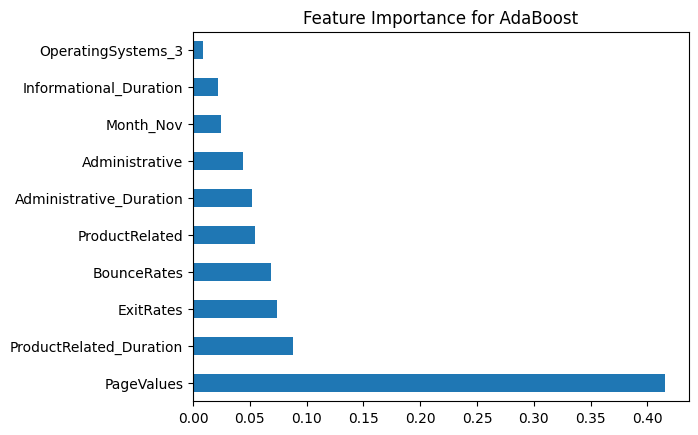

In [17]:
plot_feature_importance(ada_boost_pipeline, X_train, "AdaBoost")


# Display results


In [18]:
# Cross-Validation Results (this is fine)
results_df = pd.DataFrame(results).T

# Random Sampling (50% of the data) Results
# Convert each model's random sampling results into a DataFrame
random_results_dfs = {}
for model_name, model_scores in random_results.items():
    random_results_dfs[model_name] = pd.DataFrame(model_scores)

# AdaBoost Results (this is fine)
adaboost_results_df = pd.DataFrame(adaboost_results)

# Display Results
print("Cross-Validation Results:")
print(results_df)

print("\nRandom 50% Sampling Results (each model has a separate DataFrame):")
for model_name, df in random_results_dfs.items():
    print(f"\nRandom Sampling Results for {model_name}:")
    print(df)

print("\nAdaBoost Results:")
print(adaboost_results_df)


Cross-Validation Results:
                    Accuracy Precision    Recall  F1 Score       AUC  \
DecisionTree        0.853204   0.55792  0.574209  0.565947  0.741606   
LogisticRegression  0.871046  0.736041  0.352798  0.476974  0.889788   
KNN                 0.868613  0.700461   0.36983  0.484076   0.78366   
AdaBoost            0.854015      0.56  0.579075  0.569378  0.744039   

                             Confusion Matrix  
DecisionTree        [[1868, 187], [175, 236]]  
LogisticRegression   [[2003, 52], [266, 145]]  
KNN                  [[1990, 65], [259, 152]]  
AdaBoost            [[1868, 187], [173, 238]]  

Random 50% Sampling Results (each model has a separate DataFrame):

Random Sampling Results for DecisionTree:
   Accuracy  Precision    Recall  F1 Score       AUC  \
0  0.846310   0.537209  0.562044  0.549346  0.732603   
1  0.850770   0.551069  0.564477  0.557692  0.736253   
2  0.850770   0.552311  0.552311  0.552311  0.731387   
3  0.856853   0.569712  0.576642  0.57

# Predict using AdaBoost on the test set

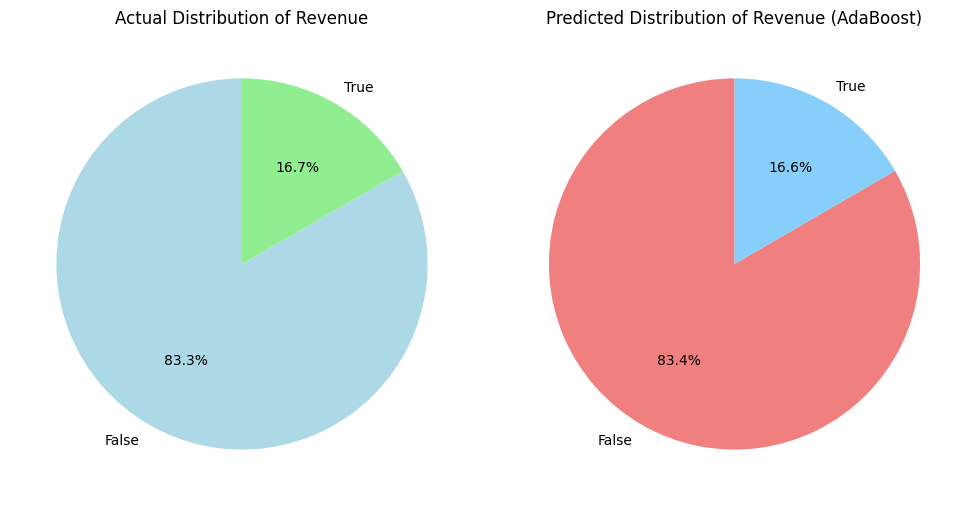

In [21]:
y_pred_ada = ada_boost_pipeline.predict(X_test)

# Count the occurrences of each class (0 and 1) for actual and predicted values
actual_counts = y_test.value_counts()
predicted_counts = pd.Series(y_pred_ada).value_counts()

# Plot the pie chart for actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(actual_counts, labels=actual_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'], startangle=90)
plt.title('Actual Distribution of Revenue')

# Plot the pie chart for predicted values
plt.subplot(1, 2, 2)
plt.pie(predicted_counts, labels=predicted_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], startangle=90)
plt.title('Predicted Distribution of Revenue (AdaBoost)')

plt.tight_layout()
plt.show()



# Group by Month and sum the Revenue column to count purchases (Revenue = 1)


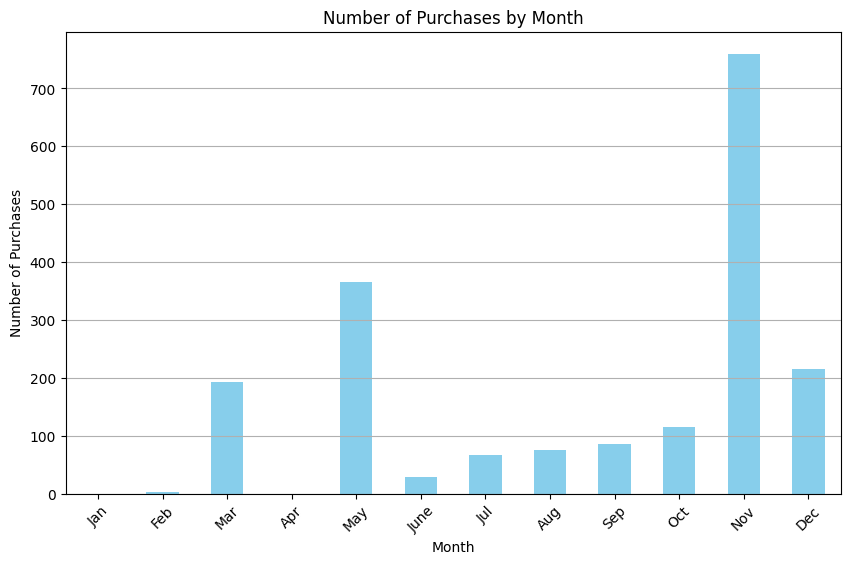

In [22]:
monthly_purchases = data.groupby('Month')['Revenue'].sum()

# Sort months in order if needed
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_purchases = monthly_purchases.reindex(month_order)

# Plot the bar chart
plt.figure(figsize=(10, 6))
monthly_purchases.plot(kind='bar', color='skyblue')

plt.title('Number of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


# Scatter plot of PageValues vs. Revenue

<Figure size 800x600 with 0 Axes>

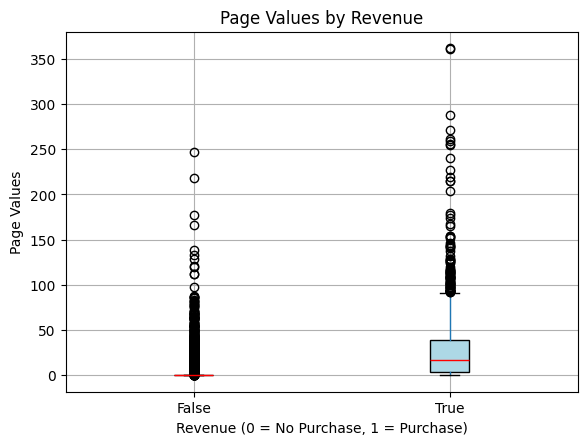

In [24]:

plt.figure(figsize=(8, 6))
data.boxplot(column='PageValues', by='Revenue', grid=False, patch_artist=True,
             boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))

plt.title('Page Values by Revenue')
plt.suptitle('')  # Suppress the automatic title from `boxplot`
plt.xlabel('Revenue (0 = No Purchase, 1 = Purchase)')
plt.ylabel('Page Values')
plt.grid(True)
plt.show()

